**TRABAJO FINAL ECONOMETRÍA**

In [ ]:
# Importación de librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy as scs
import warnings
import scipy

from scipy.stats import chi2_contingency
from scipy.stats import chi2
from scipy.stats import norm



warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def q25(x):
  return x.quantile(0.25)

def q50(x):
  return x.quantile(0.5)

def q75(x):
  return x.quantile(0.75)

def range(x):
  return x.max() - x.min()  

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/usu_individual_T221.xlsx')
df = df[['H15', 'REGION', 'CH04', 'CH06', 'CH07', 'CH08', 'CH12', 'NIVEL_ED', 'ESTADO', 'PP03D', 'PP3E_TOT', 'PP3F_TOT', 'P21', 'TOT_P12', 'P47T' ,'ITF','CAT_OCUP']].copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47085 entries, 0 to 47084
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   H15       47085 non-null  int64  
 1   REGION    47085 non-null  int64  
 2   CH04      47085 non-null  int64  
 3   CH06      47085 non-null  int64  
 4   CH07      47085 non-null  int64  
 5   CH08      47085 non-null  int64  
 6   CH12      47085 non-null  int64  
 7   NIVEL_ED  47085 non-null  int64  
 8   ESTADO    47085 non-null  int64  
 9   PP03D     19408 non-null  float64
 10  PP3E_TOT  19408 non-null  float64
 11  PP3F_TOT  19408 non-null  float64
 12  P21       47085 non-null  int64  
 13  TOT_P12   47085 non-null  int64  
 14  P47T      46996 non-null  float64
 15  ITF       47085 non-null  int64  
 16  CAT_OCUP  47085 non-null  int64  
dtypes: float64(4), int64(13)
memory usage: 6.1 MB


In [ ]:
# DataFrame con filtros. Observaciones con 18 o más años de edad y eliminando aquellas observaciones en la que no hay respuesta en NIVEL_ED
new_df = df.loc[(~df.NIVEL_ED.isin([7,9])) & (df.CH06>=17) & (df.H15 == 1) & (df.P21 != -9) & (~df.PP3E_TOT.isin([9, 99, 999, 9999]))].copy()

# Mapeo de valores de la variable independiente NIVEL_ED.
new_df['NIVEL_ED'] = new_df.NIVEL_ED.map({1:'primaria inc.',2:'primaria compl.',3:'secundaria incompl.',4:'secundaria compl.',5:'univ. incompl.',6:'univ. compl.'})

# Mapeo de valores de la variable región
new_df['REGION'] = new_df.REGION.map({1:'GBA', 40:'Noroeste', 41:'Nordeste', 42:'Cuyo', 43:'Pampeana', 44:'Patagonia'})

Text(0, 0.5, 'Conteo')

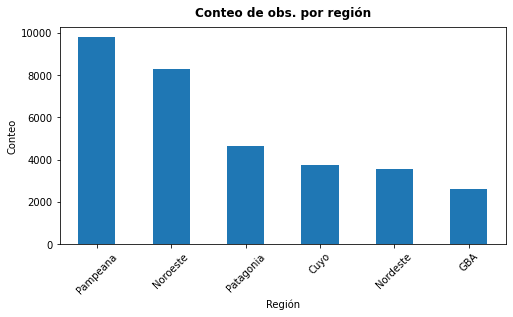

In [ ]:
# Cuantas observaciones hay en cada región?
plt.figure(figsize=(8,4))
plt.title('Conteo de obs. por región', pad=10, fontweight='bold', fontsize=12)
new_df.REGION.value_counts().plot.bar()
plt.xticks(rotation=45)
plt.xlabel('Región')
plt.ylabel('Conteo')

Text(0.5, 0, 'Edad')

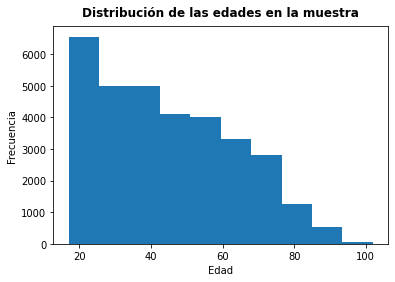

In [ ]:
# Cómo es la distribución de las edades de las personas encuestadas?
plt.figure(figsize=(6,4))
plt.title('Distribución de las edades en la muestra', pad=10, fontweight='bold', fontsize=12)
new_df.CH06.plot.hist(bins=10)
plt.ylabel('Frecuencia')
plt.xlabel('Edad')

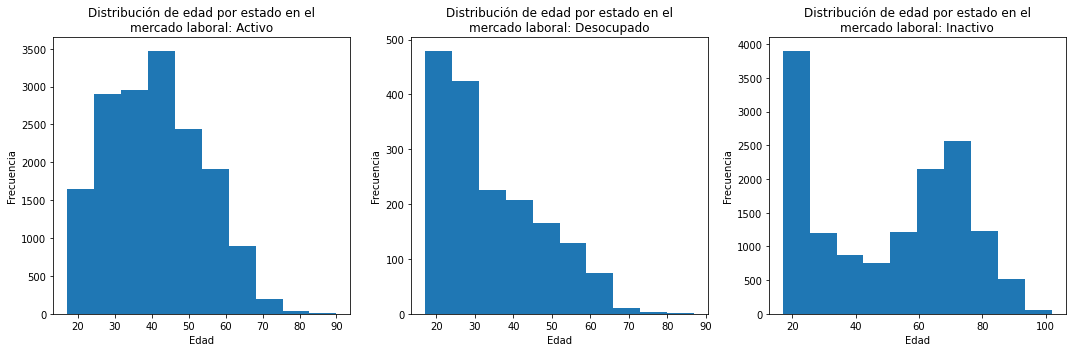

In [ ]:
for i,j in enumerate(['Activo','Desocupado','Inactivo']):
  plt.subplot(1, 3, i+1)
  new_df[new_df.ESTADO == i+1].CH06.plot.hist(figsize=(15,5), title=f'Distribución de edad por estado en el\nmercado laboral: {j}')
  plt.xlabel('Edad')
  plt.ylabel('Frecuencia')
  plt.tight_layout()

In [ ]:
# DATAFRAME QUE UTILIZAREMOS PARA HACER EL ANÁLISIS. CONTIENE SOLO A LAS PERSONAS QUE SE ENCUENTRAN EN ESTADO ACTIVO EN EL MCDO. LABORAL Y EMPLEADAS
df_final = new_df.loc[(new_df.ESTADO == 1) & (new_df.CAT_OCUP == 3)].copy()
# Binarizamos la variable continua de ingresos de los individuos en base a la canasta básica para hacerla categorica
df_final['can_basica'] = np.where(df_final.P21 >= 23922,0,1)

In [ ]:
# Conteo de personas que se encuentran por debajo y encima de la línea de pobreza (1=encima de LP, 2=debajo de LP)
df_final.can_basica.value_counts()

0    8446
1    3647
Name: can_basica, dtype: int64

Conteo de observaciones por sexo:
1    6477
2    5616
Name: CH04, dtype: int64




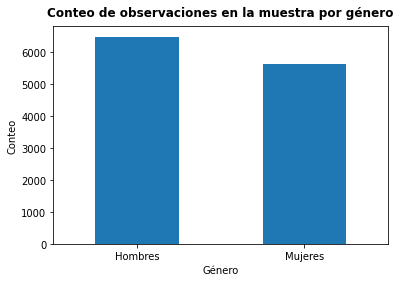

In [ ]:
# Cuantas hombres y mujeres ocupados en la PEA?
plt.title('Conteo de observaciones en la muestra por género', pad=10, fontweight='bold', fontsize=12)
df_final.CH04.value_counts().plot.bar()
plt.xticks(ticks=[0,1], labels=['Hombres','Mujeres'], rotation='horizontal')
plt.xlabel('Género')
plt.ylabel('Conteo')
print('Conteo de observaciones por sexo:\n{}'.format(df_final.CH04.value_counts()))
print('\n')

In [ ]:
pov_ed_pt = pd.crosstab(df_final.can_basica, df_final.NIVEL_ED)
pov_ed_pt.index = ['Encima LP','Debajo LP']
pov_ed_pt = pov_ed_pt[['primaria inc.','primaria compl.','secundaria incompl.','secundaria compl.','univ. incompl.','univ. compl.']]

# Prueba chi cuadrado para las frecuencias de las observaciones entre los niveles de educación y ser pobre o no
stat, p, dof, expected = chi2_contingency(pov_ed_pt.values)

if p <= 0.05:
  print('Hay dependencia entre las frecuencias observadas (rechazamos H0)')
else:
  print('No hay dependencia entre las frecuencias observadasndependent (fallamos en rechazar H0)')

print('\n')

pov_ed_pt

Hay dependencia entre las frecuencias observadas (rechazamos H0)




NIVEL_ED,primaria inc.,primaria compl.,secundaria incompl.,secundaria compl.,univ. incompl.,univ. compl.
Encima LP,135,693,1117,2658,1173,2670
Debajo LP,176,571,831,1110,601,358


Text(0, 0.5, 'Conteo')

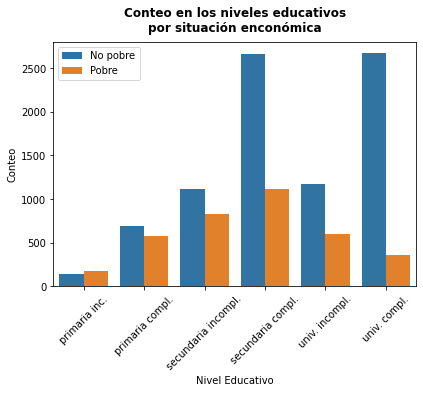

In [ ]:
# Frecuencia de observaciones en cada nivel educativo por línea de pobreza
plt.figure(figsize=(6.5,4.5))
plt.title('Conteo en los niveles educativos\npor situación enconómica', pad=10, fontweight='bold', fontsize=12)
sns.countplot(x='NIVEL_ED', data=df_final, hue='can_basica', order=['primaria inc.','primaria compl.','secundaria incompl.','secundaria compl.','univ. incompl.','univ. compl.'])
plt.xticks(rotation=45)
plt.legend(['No pobre','Pobre'])
plt.xlabel('Nivel Educativo')
plt.ylabel('Conteo')

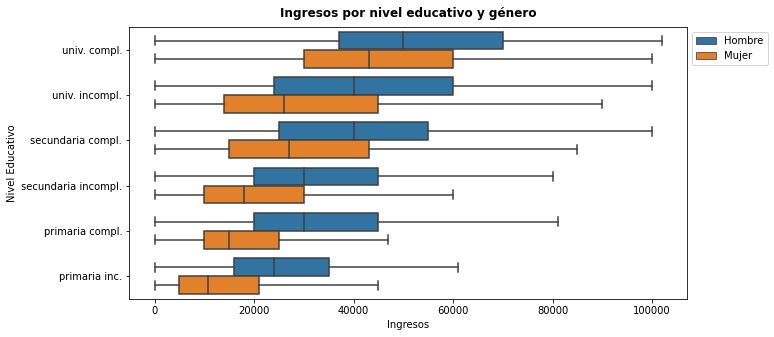

In [ ]:
# Cálculo rango intercuartílico y limites inferiores y superiores
Q25, Q75 = df_final.P21.quantile(0.25), df_final.P21.quantile(0.75)
IQR = Q75 - Q25
corte = IQR * 1.5
lim_inf, lim_sup = Q25 - corte, Q75 + corte

# Remover outliers para una mejor visualización ya que los mismos aplastan los datos contra el eje de las ordenadas
df_p21 = df_final[~((df_final.P21 < lim_inf) | (df_final.P21 > lim_sup))]
df_p21.shape[0], df_final.shape[0]

plt.figure(figsize=(10,5))
plt.title('Ingresos por nivel educativo y género', pad=10, fontweight='bold', fontsize=12)
ax = sns.boxplot(x='P21',y='NIVEL_ED',data=df_p21,hue='CH04', showfliers=False, 
                 order=['univ. compl.', 'univ. incompl.', 'secundaria compl.', 'secundaria incompl.', 'primaria compl.', 'primaria inc.'])
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['Hombre','Mujer'], bbox_to_anchor=[1, 1])
plt.xlabel('Ingresos')
plt.ylabel('Nivel Educativo')
plt.show()

In [ ]:
# Cambio % en la mediana de los ingresos de las muejeres por nivel educativo completado
df_final.groupby(['NIVEL_ED','CH04']).P21.describe().reset_index().iloc[1:-1:2].loc[[3,5,9], '50%'].pct_change()

3         NaN
5    1.500000
9    0.666667
Name: 50%, dtype: float64

In [ ]:
# Cambio % en la mediana de los ingresos de los hombres por nivel educativo completado
df_final.groupby(['NIVEL_ED','CH04']).P21.describe().reset_index().iloc[0:-1:2].loc[[0,4,8], '50%'].pct_change()

0         NaN
4    0.333333
8    0.500000
Name: 50%, dtype: float64

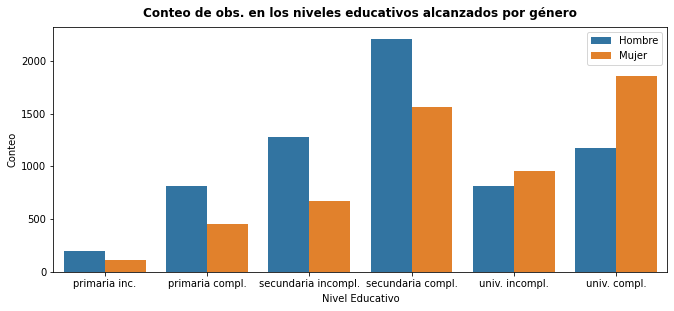

In [ ]:
plt.figure(figsize=(11,4.5))
plt.title('Conteo de obs. en los niveles educativos alcanzados por género', pad=10, fontweight='bold', fontsize=12)
sns.countplot(x='NIVEL_ED', data=df_final, hue='CH04', order=['primaria inc.','primaria compl.','secundaria incompl.','secundaria compl.','univ. incompl.','univ. compl.'])
plt.xlabel('Nivel Educativo', labelpad=5)
plt.ylabel('Conteo')
plt.legend(['Hombre','Mujer'])

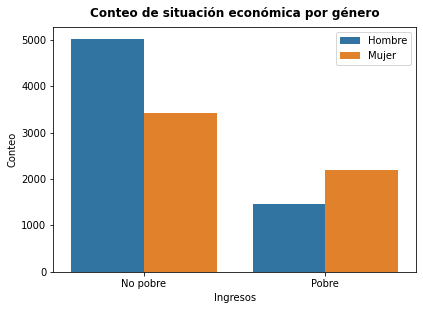

In [ ]:
plt.figure(figsize=(6.5, 4.5))
plt.title('Conteo de situación económica por género', pad=10, fontweight='bold', fontsize=12)
sns.countplot(x='can_basica', data=df_final, hue='CH04')
plt.xlabel('Ingresos')
plt.ylabel('Conteo')
plt.xticks(ticks=[0,1], labels=['No pobre', 'Pobre'])
plt.legend(['Hombre','Mujer'])

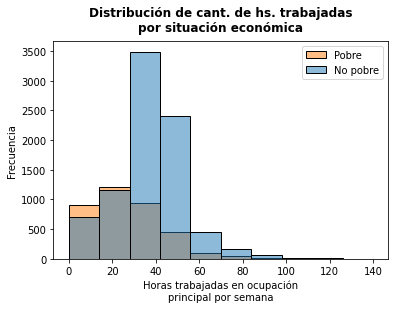

In [ ]:
plt.title('Distribución de cant. de hs. trabajadas\npor situación económica'\
          , pad=10, fontweight='bold', fontsize=12)
sns.histplot(x='PP3E_TOT', data=df_final, hue='can_basica', bins=10)
plt.xlabel('Horas trabajadas en ocupación\nprincipal por semana')
plt.ylabel('Frecuencia')
plt.legend(['Pobre','No pobre'])

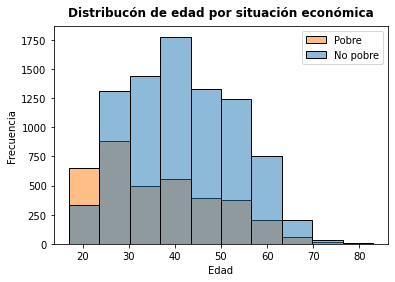

In [ ]:
# Distribución de edad discriminado por linea de pobreza
plt.title('Distribucón de edad por situación económica', pad=10, fontweight='bold', fontsize=12)
sns.histplot(x = 'CH06', data = df_final, hue = 'can_basica', bins=10)
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.legend(['Pobre','No pobre'])
plt.show()

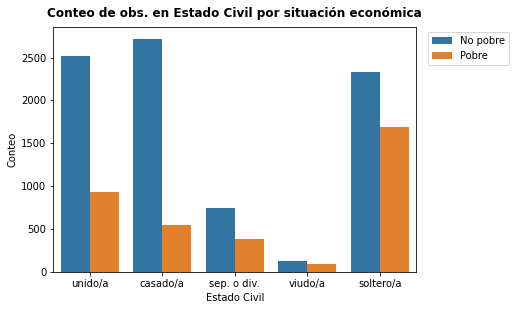

In [ ]:
plt.figure(figsize=(6.5, 4.5))
plt.title('Conteo de obs. en Estado Civil por situación económica', pad=10, fontweight='bold', fontsize=12)
sns.countplot(x='CH07', data=df_final, hue='can_basica')
plt.xticks(ticks=[0,1,2,3,4], labels=['unido/a','casado/a','sep. o div.','viudo/a','soltero/a'])
plt.xlabel('Estado Civil')
plt.ylabel('Conteo')
plt.legend(['No pobre','Pobre'], bbox_to_anchor=[1.27, 1])

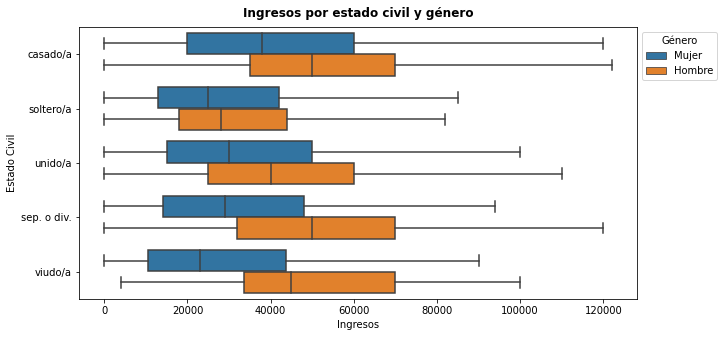

In [ ]:
tabla_descr_2 = df_final[['CH04','CH07','P21']].copy()
tabla_descr_2['CH04'] = tabla_descr_2.CH04.map({1:'Hombre',2:'Mujer'})
tabla_descr_2['CH07'] = tabla_descr_2.CH07.map({1:'unido/a',2:'casado/a',3:'sep. o div.',
                                                4:'viudo/a',5:'soltero/a'})
# Gráficar
plt.figure(figsize=(10,5))
plt.title('Ingresos por estado civil y género', pad=10, fontsize=12, fontweight='bold')
sns.boxplot(x='P21', y='CH07', data=tabla_descr_2, hue='CH04', showfliers=False)
plt.legend(bbox_to_anchor=[1, 1], title='Género')
plt.xlabel('Ingresos')
plt.ylabel('Estado Civil')
plt.show()

In [ ]:
df_final[['CH06','PP3E_TOT','P21']].agg(['min', q25, q50, q75, 'max', 'mean',range,'std','skew','kurt']).T

,min,q25,q50,q75,max,mean,range,std,skew,kurt
CH06,17.0,30.0,39.0,49.0,83.0,40.005788,66.0,12.137375,0.266150,-0.713115
PP3E_TOT,0.0,24.0,35.0,45.0,140.0,33.523956,140.0,16.830412,0.029587,0.566228
P21,0.0,20000.0,35000.0,53000.0,800000.0,41245.167783,800000.0,33042.701787,3.536326,38.262597


In [ ]:
tabla_descr = df_final[['CH04','NIVEL_ED','CH07']].copy()
tabla_descr['CH04'] = tabla_descr.CH04.map({1:'Hombre',2:'Mujer'})
tabla_descr['CH07'] = tabla_descr.CH07.map({1:'unido/a',2:'casado/a',3:'sep. o div.',
                                            4:'viudo/a',5:'soltero/a'})
tabla_descr.rename(columns={'CH04':'Sexo','NIVEL_ED':'Nivel educ.','CH07':'Estado civil'}, inplace=True)

tabla_descr.describe(include='O').T

,count,unique,top,freq
Sexo,12093,2,Hombre,6477
Nivel educ.,12093,6,secundaria compl.,3768
Estado civil,12093,5,soltero/a,4028


In [ ]:
T2 = pd.get_dummies(tabla_descr).applymap(lambda x: np.nan if x == 0 else x).describe().T[['count']]
T2.index = ['Hombre','Mujer','Primaria compl.','Primaria incompl.','Secundaria compl.',
            'Secundaria incompl.','Univ. compl.','Univ. incompl.','Casado/a','Sep. o div.',
            'Soltero/a','Unido/a','Viudo/a']
T2['percentage'] = T2/tabla_descr.shape[0]
T2

,count,percentage
Hombre,6477.0,0.535599
Mujer,5616.0,0.464401
Primaria compl.,1264.0,0.104523
Primaria incompl.,311.0,0.025717
Secundaria compl.,3768.0,0.311585
Secundaria incompl.,1948.0,0.161085
Univ. compl.,3028.0,0.250393
Univ. incompl.,1774.0,0.146696
Casado/a,3264.0,0.269908
Sep. o div.,1131.0,0.093525


**Método Heckman para control de sesgo de selección de la muestra**

https://m-clark.github.io/models-by-example/heckman-selection.html#two-step-approach

https://github.com/statsmodels/statsmodels/blob/92ea62232fd63c7b60c60bee4517ab3711d906e3/statsmodels/regression/heckman.py

https://www.econometrics-with-r.org/11-2-palr.html

***Paso 1 - Probit para obtener "inverse Mills ratio"***

In [ ]:
df['observed'] = np.where((df.ESTADO == 1) & (df.CAT_OCUP == 3), 1, 0)

In [ ]:
selection_df = df[['CH04','CH06','CH07','NIVEL_ED','PP3E_TOT','observed']].copy()

selection_df['CH04'] = selection_df.CH04.map({1:'Hombre',2:'Mujer'})
selection_df['CH07'] = selection_df.CH07.map({1:'unido',2:'casado',3:'sep./div.',4:'viudo/a',5:'soltero/a',9:'no contesta'})
selection_df['NIVEL_ED'] = selection_df.NIVEL_ED.map({1:'Primario incompleto',2:'primario completo',3:'Secundario incompleto',4:'secundario completo',
                           5:'Superior universitario incompleto',6:'Superior universitario completo',7:'Sin instrucción',
                           9:'Ns/ Nr'})
selection_df['PP3E_TOT'] = selection_df.PP3E_TOT.fillna(0)

In [ ]:
selection_df_muj = selection_df[selection_df.CH04 == 'Mujer'].drop('CH04', axis=1)
selection_df_homb = selection_df[selection_df.CH04 == 'Hombre'].drop('CH04', axis=1)

In [ ]:
X_muj = sm.add_constant(pd.concat([pd.get_dummies(selection_df_muj.drop(['observed','PP3E_TOT','CH06'], axis=1)), selection_df_muj[['CH06','PP3E_TOT']]], axis=1))
X_homb = sm.add_constant(pd.concat([pd.get_dummies(selection_df_homb.drop(['observed','PP3E_TOT','CH06'], axis=1)), selection_df_homb[['CH06','PP3E_TOT']]], axis=1))

X_muj['sqr_CH06'] = X_muj.CH06**2
X_homb['sqr_CH06'] = X_homb.CH06**2

X_muj.drop(['CH07_soltero/a','NIVEL_ED_Primario incompleto'], axis=1, inplace=True)
X_homb.drop(['CH07_soltero/a','NIVEL_ED_Primario incompleto'], axis=1, inplace=True)

*Modelo para cálcular la probabilidad de ser empleado asalariado*

In [ ]:
probit_model_muj = sm.Probit(endog=selection_df_muj.observed, exog=X_muj).fit()
print(probit_model_muj.summary())

Optimization terminated successfully.
         Current function value: 0.321326
         Iterations 26
                          Probit Regression Results                           
Dep. Variable:               observed   No. Observations:                24483
Model:                         Probit   Df Residuals:                    24468
Method:                           MLE   Df Model:                           14
Date:                Fri, 18 Feb 2022   Pseudo R-squ.:                  0.4414
Time:                        09:33:14   Log-Likelihood:                -7867.0
converged:                       True   LL-Null:                       -14084.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                      

In [ ]:
probit_model_homb = sm.Probit(endog=selection_df_homb.observed, exog=X_homb).fit()
print(probit_model_homb.summary())

         Current function value: 0.373306
         Iterations: 35
                          Probit Regression Results                           
Dep. Variable:               observed   No. Observations:                22602
Model:                         Probit   Df Residuals:                    22587
Method:                           MLE   Df Model:                           14
Date:                Fri, 18 Feb 2022   Pseudo R-squ.:                  0.4147
Time:                        09:33:15   Log-Likelihood:                -8437.5
converged:                      False   LL-Null:                       -14415.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                         -3.4573      0.082    -42.319     

In [ ]:
selection_df_muj['mills_ratio'] = norm.pdf(probit_model_muj.fittedvalues)/norm.cdf(probit_model_muj.fittedvalues)
selection_df_homb['mills_ratio'] = norm.pdf(probit_model_homb.fittedvalues)/norm.cdf(probit_model_homb.fittedvalues)

In [ ]:
obs_index_homb = selection_df_homb.observed == 1
obs_index_muj = selection_df_muj.observed == 1

df_homb = selection_df_homb[obs_index_homb].copy()
df_muj = selection_df_muj[obs_index_muj].copy()

***Paso 2 - Regresión Logistica***

In [ ]:
df_final_homb = df_final[df_final.CH04 == 1].join(df_homb.mills_ratio)
df_final_muj = df_final[df_final.CH04 == 2].join(df_muj.mills_ratio)

In [ ]:
df_final_homb['sqr_CH06'] = df_final_homb.CH06**2
df_final_muj['sqr_CH06'] = df_final_muj.CH06**2

In [ ]:
# Variables explicativas hombres
X_log_homb = df_final_homb[['CH06','sqr_CH06','NIVEL_ED','PP3E_TOT','mills_ratio']].copy()

# Variables explicativas mujeres
X_log_muj = df_final_muj[['CH06','sqr_CH06','NIVEL_ED','PP3E_TOT','mills_ratio']].copy()

# Variables dependientes hombres y mujeres
y_log_hom = df_final_homb.can_basica.copy()
y_log_muj = df_final_muj.can_basica.copy()

*Hombre*

In [ ]:
t_model_homb_1 = sm.Logit(y_log_hom, sm.add_constant(pd.get_dummies(X_log_homb['NIVEL_ED']).drop(['primaria inc.'], axis=1).join(X_log_homb['mills_ratio']))).fit()
print(t_model_homb_1.summary())

Optimization terminated successfully.
         Current function value: 0.476494
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             can_basica   No. Observations:                 6477
Model:                          Logit   Df Residuals:                     6470
Method:                           MLE   Df Model:                            6
Date:                Fri, 18 Feb 2022   Pseudo R-squ.:                  0.1046
Time:                        09:33:15   Log-Likelihood:                -3086.3
converged:                       True   LL-Null:                       -3446.7
Covariance Type:            nonrobust   LLR p-value:                1.876e-152
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.8277      0.173    -10.579      0.000      -2.166      -1.489
pr

In [ ]:
t_model_homb_2 = sm.Logit(y_log_hom, sm.add_constant(pd.get_dummies(X_log_homb['NIVEL_ED']).drop(['primaria inc.'], axis=1).join(X_log_homb[['CH06','sqr_CH06','PP3E_TOT','mills_ratio']]))).fit()
print(t_model_homb_2.summary())

Optimization terminated successfully.
         Current function value: 0.425876
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             can_basica   No. Observations:                 6477
Model:                          Logit   Df Residuals:                     6467
Method:                           MLE   Df Model:                            9
Date:                Fri, 18 Feb 2022   Pseudo R-squ.:                  0.1997
Time:                        09:33:15   Log-Likelihood:                -2758.4
converged:                       True   LL-Null:                       -3446.7
Covariance Type:            nonrobust   LLR p-value:                8.770e-291
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.4865      1.670      0.291      0.771      -2.786       3.759
pr

*Mujer*

In [ ]:
t_model_muj_1 = sm.Logit(y_log_muj, sm.add_constant(pd.get_dummies(X_log_muj['NIVEL_ED']).drop(['primaria inc.'], axis=1).join(X_log_muj['mills_ratio']))).fit()
print(t_model_muj_1.summary())

Optimization terminated successfully.
         Current function value: 0.542637
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             can_basica   No. Observations:                 5616
Model:                          Logit   Df Residuals:                     5609
Method:                           MLE   Df Model:                            6
Date:                Fri, 18 Feb 2022   Pseudo R-squ.:                  0.1890
Time:                        09:33:15   Log-Likelihood:                -3047.5
converged:                       True   LL-Null:                       -3757.8
Covariance Type:            nonrobust   LLR p-value:                7.905e-304
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.6804      0.260     -2.614      0.009      -1.191      -0.170
pr

In [ ]:
t_model_muj_2 = sm.Logit(y_log_muj, sm.add_constant(pd.get_dummies(X_log_muj['NIVEL_ED']).drop(['primaria inc.'], axis=1).join(X_log_muj[['CH06','sqr_CH06','PP3E_TOT','mills_ratio']]))).fit()
print(t_model_muj_2.summary())

Optimization terminated successfully.
         Current function value: 0.501748
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             can_basica   No. Observations:                 5616
Model:                          Logit   Df Residuals:                     5606
Method:                           MLE   Df Model:                            9
Date:                Fri, 18 Feb 2022   Pseudo R-squ.:                  0.2501
Time:                        09:33:15   Log-Likelihood:                -2817.8
converged:                       True   LL-Null:                       -3757.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  12.8323      1.119     11.466      0.000      10.639      15.026
pr

*EXTRAS*

https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.LogitResults.get_margeff.html

In [ ]:
print(t_model_homb_2.get_margeff().summary())

        Logit Marginal Effects       
Dep. Variable:             can_basica
Method:                          dydx
At:                           overall
                         dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
primaria compl.        -0.0156      0.029     -0.537      0.591      -0.073       0.041
secundaria compl.      -0.1250      0.033     -3.807      0.000      -0.189      -0.061
secundaria incompl.    -0.0892      0.027     -3.251      0.001      -0.143      -0.035
univ. compl.           -0.2344      0.039     -6.004      0.000      -0.311      -0.158
univ. incompl.         -0.1441      0.031     -4.647      0.000      -0.205      -0.083
CH06                   -0.0063      0.006     -0.978      0.328      -0.019       0.006
sqr_CH06            -4.075e-05   8.09e-05     -0.504      0.615      -0.000       0.000
PP3E_TOT               -0.0004      0.001     -0.311    

In [ ]:
print(t_model_muj_2.get_margeff().summary())

        Logit Marginal Effects       
Dep. Variable:             can_basica
Method:                          dydx
At:                           overall
                         dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
primaria compl.        -0.0726      0.045     -1.607      0.108      -0.161       0.016
secundaria compl.      -0.3573      0.043     -8.256      0.000      -0.442      -0.272
secundaria incompl.    -0.2020      0.044     -4.618      0.000      -0.288      -0.116
univ. compl.           -0.6668      0.046    -14.388      0.000      -0.758      -0.576
univ. incompl.         -0.4189      0.044     -9.490      0.000      -0.505      -0.332
CH06                   -0.0538      0.005     -9.930      0.000      -0.064      -0.043
sqr_CH06                0.0005   6.47e-05      8.344      0.000       0.000       0.001
PP3E_TOT               -0.0142      0.001    -13.173    